In [188]:
import pandas as pd
import numpy as np
import import_ipynb
import utils_cdt as cdtsql
from datetime import datetime
from datetime import date
import plotly.express as px
from pyspark.sql import SparkSession, Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.storagelevel import StorageLevel 

In [189]:
def normalizaDados(df, dia_em_corte):
    df = df.round(2)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    df['DataVencimentoPadrao'] = pd.to_datetime(df.DataVencimentoPadrao, format="%d/%m/%Y")
    df['ano'] = df['DataVencimentoPadrao'].dt.year
    df['mes'] = df['DataVencimentoPadrao'].dt.month
    df['dia'] = df['DataVencimentoPadrao'].dt.day
    df = df.loc[df.dia == dia_em_corte]
    
    df = df.loc[df.DataVencimentoPadrao != '2079-01-01']
    return df

In [190]:
def cache(self): 
    """ 
    Persist this RDD with the default storage level (C{MEMORY_ONLY_SER}). 
    """ 
    self.is_cached = True 
    self.persist(StorageLevel.MEMORY_ONLY_SER) 
    return self 

In [191]:
spark = SparkSession \
    .builder \
    .appName("Modelo - Spark") \
    .config("spark.executor.memory", "4gb") \
    .config("spark.driver.host","127.0.0.1") \
    .getOrCreate()

sc = spark.sparkContext
sc = SQLContext(sc)

In [192]:
infoDataBases = {"ip":"",
                 "base":""}
dia_em_corte = 5

In [193]:
emissor = infoDataBases["base"]
consulta = cdtsql.resultQuery("transacoescorrentes.sql")
inicio = '2020-01-01' 
fim = '2020-02-28'
consulta = consulta.format(inicio = inicio, fim = fim)
df_transacoescorrentes = cdtsql.extrairDados(infoDataBases,consulta,
                                            path="../data/transacoescorrentes/",
                                            arquivo=f"transacoescorrentes_{emissor}",
                                            spark=False,objSpark=None)

arquivoExiste


In [194]:
df = normalizaDados(df_transacoescorrentes,dia_em_corte)
df_spark = spark.createDataFrame(df)

In [195]:
# Atribui em memoria o novo dataset.
dados = cache(df_spark)

# Registra dataset como tabela do SQL.
dados.registerTempTable("dados")

In [196]:
codigo_cred = f"""SELECT *
            FROM dados
            WHERE
            SaldoAtualFinal = -1 AND
            DAY(DataVencimentoPadrao) = '{dia_em_corte}'
"""

codigo_deb = f"""SELECT *
            FROM dados
            WHERE
            SaldoAtualFinal = 1 AND
            (Nome LIKE '%seguro%' OR Nome LIKE '%seg%' OR Nome Like '%IOF%') AND
            DAY(DataVencimentoPadrao) = '{dia_em_corte}'
"""


In [197]:
credito = sc.sql(codigo_cred)
# Registra dataset como tabela do SQL.
credito.registerTempTable("credito")

debito = sc.sql(codigo_deb)
# Registra dataset como tabela do SQL.
debito.registerTempTable("debito")

In [198]:
debito.show(4)

+----------------+--------------------+--------------------+---------------+---------+---------+----+---+---+
|Id_tipoTransacao|                Nome|DataVencimentoPadrao|SaldoAtualFinal|    total|registros| ano|mes|dia|
+----------------+--------------------+--------------------+---------------+---------+---------+----+---+---+
|             117|        IOF ROTATIVO| 2020-03-05 00:00:00|            1.0|181769.56|   107562|2020|  3|  5|
|             117|        IOF ROTATIVO| 2020-02-05 00:00:00|            1.0|167729.44|   105155|2020|  2|  5|
|             461|IOF TRANSACOES EX...| 2020-03-05 00:00:00|            1.0|   908.72|       92|2020|  3|  5|
|             591|   IOF ACORDO CRELIQ| 2020-03-05 00:00:00|            1.0|217218.81|     8300|2020|  3|  5|
+----------------+--------------------+--------------------+---------------+---------+---------+----+---+---+
only showing top 4 rows



In [199]:
mdStd_credito = f"""

            SELECT 
            Id_TipoTransacao,
            Nome,
            ROUND(SUM(total),2) as total,
            ROUND(AVG(total),2) as media,
            ROUND(STD(total),2) as desviopadrao
            FROM credito
            GROUP BY Id_TipoTransacao, Nome

"""
mdStd_credito = sc.sql(mdStd_credito)
# Registra dataset como tabela do SQL.
mdStd_credito.registerTempTable("mdstd_credito")

In [200]:
mdStd_debito = f"""

            SELECT 
            Id_TipoTransacao,
            Nome,
            ROUND(SUM(total),2) as total,
            ROUND(AVG(total),2) as media,
            ROUND(STD(total),2) as desviopadrao
            FROM debito
            GROUP BY Id_TipoTransacao, Nome

"""
mdStd_debito = sc.sql(mdStd_debito)
# Registra dataset como tabela do SQL.
mdStd_debito.registerTempTable("mdstd_debito")

In [201]:
mdStd_debito.show(20)

+----------------+--------------------+---------+---------+------------+
|Id_TipoTransacao|                Nome|    total|    media|desviopadrao|
+----------------+--------------------+---------+---------+------------+
|             609|       DEBITO DE IOF|396597.94|132199.31|   104277.12|
|            9807|Microsseguro de D...|383564.17|127854.72|   115012.62|
|            9801| Microsseguro Mulher|363330.01| 121110.0|   107178.67|
|             593|IOF SOBRE ACORDO ...| 12759.21|  4253.07|     3065.11|
|             591|   IOF ACORDO CRELIQ|482558.65|160852.88|   114335.39|
|             746|IOF SUGESTAO FINA...|  9548.19|  4774.09|      517.04|
|             117|        IOF ROTATIVO| 349499.0| 174749.5|     9927.86|
|             461|IOF TRANSACOES EX...|  1657.64|   828.82|       113.0|
+----------------+--------------------+---------+---------+------------+



In [202]:
finalcredito = f"""
        SELECT 
        A.*,
        (A.total - B.media) / b.desviopadrao AS zscore
        FROM credito AS A
        INNER JOIN mdstd_credito AS B ON (B.Id_TipoTransacao = A.Id_TipoTransacao)
"""
finalcredito = sc.sql(finalcredito)
# Registra dataset como tabela do SQL.
finalcredito.registerTempTable("finalcredito")

In [203]:
finalcredito = finalcredito.toPandas()

In [204]:
finaldebito = f"""
        SELECT 
        A.*,
        (A.total - B.media) / b.desviopadrao AS zscore
        FROM debito AS A
        INNER JOIN mdstd_debito AS B ON (B.Id_TipoTransacao = A.Id_TipoTransacao)
"""
finaldebito = sc.sql(finaldebito)
# Registra dataset como tabela do SQL.
finaldebito.registerTempTable("finaldebito")

In [205]:
finaldebito = finaldebito.toPandas()

In [212]:
finaldebito.ano.count()

21

In [206]:
finaldebito.sort_values('zscore', ascending=True).head(40)

,Id_tipoTransacao,Nome,DataVencimentoPadrao,SaldoAtualFinal,total,registros,ano,mes,dia,zscore
13,591,IOF ACORDO CRELIQ,2020-04-05,1.0,29278.71,1017,2020,4,5,-1.150774
9,609,DEBITO DE IOF,2020-04-05,1.0,12865.34,550,2020,4,5,-1.144393
6,593,IOF SOBRE ACORDO PERDA,2020-04-05,1.0,786.04,46,2020,4,5,-1.131127
16,9801,Microsseguro Mulher,2020-04-05,1.0,43.98,2,2020,4,5,-1.129572
20,9807,Microsseguro de Danos Residencial e de Pessoas,2020-04-05,1.0,13.99,1,2020,4,5,-1.111537
1,117,IOF ROTATIVO,2020-02-05,1.0,167729.44,105155,2020,2,5,-0.707107
14,746,IOF SUGESTAO FINANCIAMENTO,2020-02-05,1.0,4408.49,359,2020,2,5,-0.707102
11,461,IOF TRANSACOES EXTERIOR R$,2020-02-05,1.0,748.92,98,2020,2,5,-0.707080
17,9807,Microsseguro de Danos Residencial e de Pessoas,2020-03-05,1.0,160622.84,11600,2020,3,5,0.284909
18,9801,Microsseguro Mulher,2020-03-05,1.0,159404.95,7283,2020,3,5,0.357300


In [209]:
finaldebito.loc[finaldebito.Id_tipoTransacao == 593]

,Id_tipoTransacao,Nome,DataVencimentoPadrao,SaldoAtualFinal,total,registros,ano,mes,dia,zscore
4,593,IOF SOBRE ACORDO PERDA,2020-02-05,1.0,5370.41,342,2020,2,5,0.364535
5,593,IOF SOBRE ACORDO PERDA,2020-03-05,1.0,6602.76,402,2020,3,5,0.766592
6,593,IOF SOBRE ACORDO PERDA,2020-04-05,1.0,786.04,46,2020,4,5,-1.131127


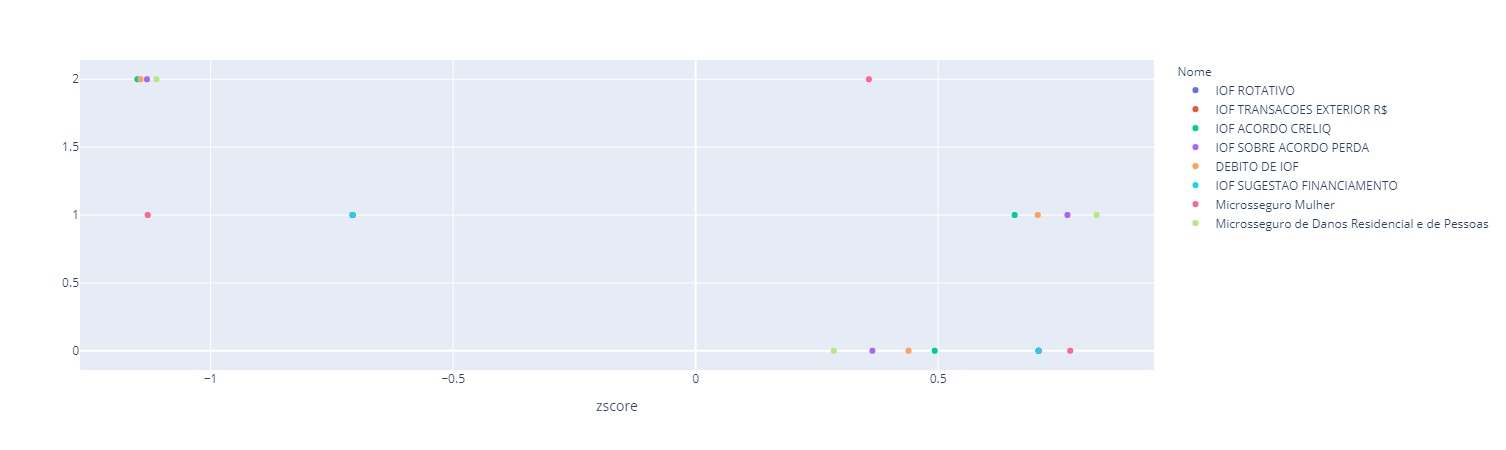

In [210]:
import plotly.express as px
fig = px.scatter(finaldebito, x="zscore", color="Nome")
fig.show()